# Characterizing and Predicting Dog Adoption Rates

I am using data sets I obtained from Kaggle: [dog breeds parameters scraped from at dogtime.com](https://www.kaggle.com/hocop1/cat-and-dog-breeds-parameters) and the Austin Animal Center's [intake and outake records.](https://www.kaggle.com/aaronschlegel/austin-animal-center-shelter-intakes-and-outcomes/) 

In [156]:
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import json
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from zipfile import ZipFile
from scipy.stats import boxcox
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_validate
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [2]:
!cd ../data_sets/ & ls

Capstone_supervised_learning_notes.ipynb
README.md
aac_intakes_outcomes.csv
dog_adoption_SL_capstone.ipynb
rating.json


The system cannot find the path specified.


### Shelter dataset exploration and cleaning

In [62]:
raw = pd.read_csv(r'aac_intakes_outcomes.csv')  # I will used the merged file with both intake records and outcome records
shelter_inout_df = raw.copy(deep=True)


In [63]:
shelter_inout_df.animal_type.unique()

array(['Dog', 'Cat', 'Other', 'Bird'], dtype=object)

In [64]:
#we are only looking at dogs
shelter_inout_df = shelter_inout_df[shelter_inout_df.animal_type == 'Dog']

# there are a lot of features that i'm not interested, especially that describe the same thing in multiple ways. 
# I am using time in shelter as it is a simple scalar, not d datetime. 
#count is only 1, no other values exist

shelter_inout_df = shelter_inout_df.drop(columns=['animal_type', "age_upon_outcome", "animal_id_outcome", "age_upon_outcome_(years)", 
                                                  'age_upon_outcome_(days)', "age_upon_outcome_age_group", "outcome_year", 
                                                  "outcome_monthyear", "outcome_hour", "outcome_number", "animal_id_intake", 
                                                  "age_upon_intake_(years)", "age_upon_intake_age_group", "intake_year", 
                                                  "intake_monthyear", "intake_hour", "intake_number", "time_in_shelter", 
                                                  "found_location", 'outcome_datetime', 'dob_year', 'dob_month', 'dob_monthyear',
                                                  'outcome_month', 'outcome_weekday', 'age_upon_intake', 'intake_month',
                                                  'date_of_birth'])
shelter_inout_df.shape

(45366, 13)

In [65]:
def season_of_date(date_in):
    date = pd.to_datetime(date_in)
    year = str(date.year)
    seasons = {'spring': pd.date_range(start='21/03/'+year, end='20/06/'+year),
               'summer': pd.date_range(start='21/06/'+year, end='22/09/'+year),
               'autumn': pd.date_range(start='23/09/'+year, end='20/12/'+year)}
    if date in seasons['spring']:
        return 'spring'
    if date in seasons['summer']:
        return 'summer'
    if date in seasons['autumn']:
        return 'autumn'
    else:
        return 'winter'

shelter_inout_df["intake_season"] = shelter_inout_df.intake_datetime.transform(season_of_date)

In [67]:
shelter_inout_df = pd.merge(left=shelter_inout_df, right=pd.get_dummies(shelter_inout_df.intake_season, drop_first=True), 
                            left_index=True, right_index=True, how='left')
shelter_inout_df = shelter_inout_df.drop(columns=['intake_season'])                              

In [68]:
#these two features can be simplified to sex, neutered, and if neutering occured
shelter_inout_df.pivot_table(index='sex_upon_intake', columns='sex_upon_outcome', values='count', aggfunc=np.sum)

sex_upon_outcome,Intact Female,Intact Male,Neutered Male,Spayed Female,Unknown
sex_upon_intake,,,,,
Intact Female,4139.0,NaN,NaN,8656.0,NaN
Intact Male,NaN,4854.0,9978.0,NaN,NaN
Neutered Male,NaN,NaN,9452.0,NaN,NaN
Spayed Female,NaN,NaN,NaN,8045.0,NaN
Unknown,NaN,NaN,NaN,NaN,241.0


In [69]:
shelter_inout_df[shelter_inout_df.sex_upon_outcome.isna()]

,outcome_subtype,outcome_type,sex_upon_outcome,breed,color,intake_condition,intake_type,sex_upon_intake,count,age_upon_intake_(days),intake_datetime,intake_weekday,time_in_shelter_days,spring,summer,winter
6523,NaN,Return to Owner,NaN,Dachshund,Brown Merle,Normal,Owner Surrender,NaN,1,2555,2013-11-17 13:15:00,Sunday,10.122222,0,0,1


In [70]:
#change nulls to 'unknown'
shelter_inout_df.loc[shelter_inout_df.sex_upon_intake.isna(), 'sex_upon_intake'] = 'Unknown'
shelter_inout_df.loc[shelter_inout_df.sex_upon_outcome.isna(), 'sex_upon_outcome'] = 'Unknown'

In [71]:
shelter_inout_df["neutered"] = shelter_inout_df.sex_upon_outcome.str.split(expand=True)[0]
shelter_inout_df["neutered"] = shelter_inout_df.neutered.apply(lambda x: x!='Intact').astype(int)

shelter_inout_df["male"] = shelter_inout_df.sex_upon_intake.str.split(expand=True)[1]
shelter_inout_df["male"] = shelter_inout_df.male.apply(lambda x: x=='Male').astype(int)

#use halfway value for unknowns 
shelter_inout_df[shelter_inout_df.sex_upon_intake == 'Unknown'].loc[:,"neutered" : "male"] = .5, .5  # halfway values

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [72]:
def was_neutered(x):
    intake_type = x.sex_upon_intake.split()[0]
    outcome_type = x.sex_upon_outcome.split()[0]
    if intake_type == outcome_type:
        neutered = 0
    else:
        neutered = 1
    return neutered
shelter_inout_df['neutered_in_shelter'] = shelter_inout_df.apply(was_neutered, axis=1)

In [73]:
shelter_inout_df = shelter_inout_df.drop(columns=['sex_upon_outcome'])

In [74]:
shelter_inout_df.isna().sum()

outcome_subtype           31598
outcome_type                  2
breed                         0
color                         0
intake_condition              0
intake_type                   0
sex_upon_intake               0
count                         0
age_upon_intake_(days)        0
intake_datetime               0
intake_weekday                0
time_in_shelter_days          0
spring                        0
summer                        0
winter                        0
neutered                      0
male                          0
neutered_in_shelter           0
dtype: int64

In [75]:
#outcome is source of nulls - will deal with in creating y

In [76]:
#encode color feature
shelter_inout_df.color.head()

0    Yellow/White
1    Yellow/White
2    Yellow/White
3        Tricolor
4     Brown/White
Name: color, dtype: object

In [77]:
shelter_inout_df["color1"] = ""  #errors when assigning to multiple columns before they are created
shelter_inout_df["color2"] = ""
shelter_inout_df["color1"] = shelter_inout_df["color"].str.split(pat="/", expand=True)[0]
shelter_inout_df["color2"] = shelter_inout_df["color"].str.split(pat="/", expand=True)[1]

In [78]:
shelter_inout_df["color_type"] = shelter_inout_df.color1.str.split(expand=True)[1]
shelter_inout_df["color1"] = shelter_inout_df.color1.str.split(expand=True)[0]
shelter_inout_df["color_type2"] = shelter_inout_df.color2.str.split(expand=True)[1]
shelter_inout_df["color2"] = shelter_inout_df.color2.str.split(expand=True)[0]

In [79]:
shelter_inout_df.color_type.unique()

array([None, 'Merle', 'Brindle', 'Tick', 'Tiger', 'Smoke', 'Cream'],
      dtype=object)

In [80]:
shelter_inout_df.color_type2.unique()

array([None, 'Brindle', 'Merle', 'Tick', 'Tiger', 'Cream', 'Tabby',
       'Smoke'], dtype=object)

In [81]:
#Check how many colors there are
pd.concat([shelter_inout_df.color1, shelter_inout_df.color2], 0).value_counts()

White        24186
Black        15704
Brown        11776
Tan           9255
Red           2623
Blue          2559
Tricolor      2454
Chocolate     1309
Gray           855
Cream          850
Sable          745
Yellow         744
Buff           666
Fawn           590
Gold           203
Silver         174
Apricot         76
Liver           72
Orange          40
Pink             4
Agouti           4
Ruddy            1
Tortie           1
dtype: int64

In [82]:
#Put values from both color fields into same set of dummy fields
color_df = pd.get_dummies(shelter_inout_df[["color1", "color2"]], drop_first=True)
color_list = pd.Series(color_df.columns.values)
color_list = pd.concat([color_list, color_list.str.split(pat='_', expand=True)], axis=1)
color_list.columns = ['fullname', 'source', 'colorname']

In [83]:
for color in color_list["colorname"].unique():
    shelter_inout_df[color] = 0
    shelter_inout_df.loc[(shelter_inout_df["color1"]==color) | (shelter_inout_df["color2"]==color),color] = 1
shelter_inout_df = shelter_inout_df.drop(columns=['color', 'color1', 'color2'])    

In [84]:
#review which outcomes have which subtypes
outcome_pivot = shelter_inout_df.pivot_table(values='breed', index='outcome_type', columns='outcome_subtype', aggfunc=len)
outcome_pivot

outcome_subtype,Aggressive,At Vet,Barn,Behavior,Court/Investigation,Enroute,Foster,In Foster,In Kennel,In Surgery,Medical,Offsite,Partner,Possible Theft,Rabies Risk,Suffering
outcome_type,,,,,,,,,,,,,,,,
Adoption,NaN,NaN,NaN,NaN,NaN,NaN,2174.0,NaN,NaN,NaN,NaN,254.0,NaN,NaN,NaN,NaN
Died,NaN,15.0,NaN,NaN,NaN,5.0,NaN,18.0,89.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN
Euthanasia,492.0,12.0,NaN,133.0,23.0,NaN,NaN,NaN,NaN,NaN,61.0,NaN,NaN,NaN,86.0,690.0
Missing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,NaN,NaN,NaN,NaN,7.0,NaN,NaN
Return to Owner,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Transfer,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9696.0,NaN,NaN,NaN


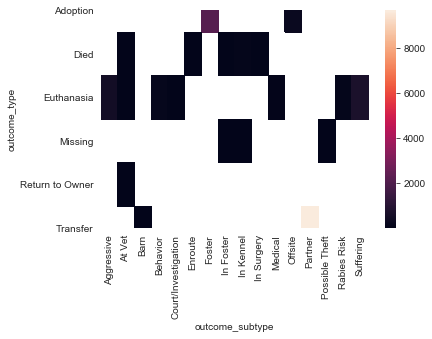

In [85]:
sns.set_style("whitegrid")
sns.heatmap(outcome_pivot);

In [86]:
# The outcome subtypes don't seem to asking the same type of questions but they are part of the outcome and can't be used to predict
shelter_inout_df.drop(columns=["outcome_subtype"], inplace=True)

In [87]:
shelter_inout_df = pd.concat([shelter_inout_df, pd.get_dummies(shelter_inout_df.intake_weekday, drop_first=True)], axis=1)

### Import the dog breed descriptions and inspect data

In [88]:
with open('rating.json', 'r') as rating_file:
    ratings = json.load(rating_file)
    json_normalize(ratings)
    dog_descr_df = pd.DataFrame.from_dict(ratings['dog_breeds'], ).T
dog_descr_df.head()

,Adaptability,All Around Friendliness,Exercise Needs,Health Grooming,Trainability,Adapts Well to Apartment Living,Affectionate with Family,Amount Of Shedding,Dog Friendly,Drooling Potential,Easy To Groom,Easy To Train,Energy Level,Exercise Needs,Friendly Toward Strangers,General Health,Good For Novice Owners,Incredibly Kid Friendly Dogs,Intelligence,Intensity,Potential For Mouthiness,Potential For Playfulness,Potential For Weight Gain,Prey Drive,Sensitivity Level,Size,Tendency To Bark Or Howl,Tolerates Being Alone,Tolerates Cold Weather,Tolerates Hot Weather,Wanderlust Potential
Affenpinscher,3.0,3.0,4.0,2.0,3.0,5.0,5.0,1.0,4.0,1.0,3.0,2.0,4.0,3.0,3.0,4.0,4.0,1.0,4.0,3.0,4.0,4.0,3.0,3.0,3.0,1.0,2.0,1.0,3.0,3.0,2.0
Afghan Hound,4.0,4.0,4.0,2.0,3.0,5.0,5.0,4.0,4.0,1.0,1.0,1.0,5.0,4.0,2.0,3.0,3.0,5.0,4.0,2.0,3.0,4.0,1.0,5.0,5.0,4.0,2.0,2.0,5.0,5.0,5.0
Airedale Terrier,2.0,4.0,5.0,3.0,5.0,1.0,4.0,2.0,4.0,1.0,2.0,4.0,5.0,5.0,3.0,3.0,2.0,4.0,5.0,3.0,5.0,5.0,4.0,5.0,3.0,3.0,4.0,2.0,3.0,3.0,4.0
Akita,3.0,2.0,4.0,4.0,4.0,2.0,5.0,5.0,1.0,5.0,1.0,2.0,4.0,4.0,2.0,4.0,2.0,1.0,3.0,3.0,3.0,5.0,4.0,4.0,5.0,4.0,5.0,1.0,5.0,2.0,4.0
Alaskan Klee Kai,3.0,3.0,4.0,3.0,4.0,3.0,4.0,4.0,2.0,2.0,4.0,4.0,4.0,4.0,2.0,4.0,2.0,3.0,4.0,2.0,2.0,4.0,2.0,5.0,4.0,2.0,3.0,2.0,5.0,2.0,4.0


In [89]:
dog_descr_df.describe()

,Adaptability,All Around Friendliness,Exercise Needs,Health Grooming,Trainability,Adapts Well to Apartment Living,Affectionate with Family,Amount Of Shedding,Dog Friendly,Drooling Potential,Easy To Groom,Easy To Train,Energy Level,Exercise Needs,Friendly Toward Strangers,General Health,Good For Novice Owners,Incredibly Kid Friendly Dogs,Intelligence,Intensity,Potential For Mouthiness,Potential For Playfulness,Potential For Weight Gain,Prey Drive,Sensitivity Level,Size,Tendency To Bark Or Howl,Tolerates Being Alone,Tolerates Cold Weather,Tolerates Hot Weather,Wanderlust Potential
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,3.116822,4.070093,4.107477,2.995327,3.560748,3.074766,4.700935,3.014019,3.551402,1.705607,3.350467,3.560748,4.093458,4.079439,3.420561,3.425234,2.864486,4.112150,4.070093,3.336449,3.126168,4.364486,3.294393,3.593458,3.892523,2.841121,3.121495,2.037383,3.331776,3.074766,3.443925
std,0.565351,0.827771,0.818013,0.601232,0.623146,1.575642,0.560264,1.231355,1.227491,1.215034,1.418713,1.147993,0.949749,0.996825,1.191026,1.039826,1.208480,1.068781,0.731416,1.095822,1.006070,0.803660,0.950545,1.201780,0.818013,1.155916,1.227313,0.953622,1.209206,0.941490,1.208008
min,2.000000,1.000000,2.000000,2.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,3.000000,4.000000,4.000000,3.000000,3.000000,1.000000,4.000000,2.000000,3.000000,1.000000,2.000000,3.000000,4.000000,3.000000,3.000000,3.000000,2.000000,4.000000,4.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,2.000000,2.000000,1.000000,3.000000,3.000000,3.000000
50%,3.000000,4.000000,4.000000,3.000000,4.000000,3.000000,5.000000,3.000000,4.000000,1.000000,3.500000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,4.000000,4.000000,3.000000,3.000000,5.000000,3.000000,4.000000,4.000000,3.000000,3.000000,2.000000,4.000000,3.000000,4.000000
75%,3.000000,5.000000,5.000000,3.000000,4.000000,5.000000,5.000000,4.000000,5.000000,2.000000,5.000000,4.000000,5.000000,5.000000,4.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,4.000000,4.000000,3.000000,4.000000,4.000000,4.000000
max,4.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [90]:
dog_descr_df.columns = dog_descr_df.columns.str.strip()
dog_descr_df.columns = dog_descr_df.columns.str.replace(" ", "_")

In [91]:
dog_descr_df.Exercise_Needs.head()

,Exercise_Needs,Exercise_Needs
Affenpinscher,4.0,3.0
Afghan Hound,4.0,4.0
Airedale Terrier,5.0,5.0
Akita,4.0,4.0
Alaskan Klee Kai,4.0,4.0


In [92]:
# Combine two identical features into one
dog_descr_df.columns.get_loc("Exercise_Needs").nonzero()  # get column numbers

(array([ 2, 13], dtype=int64),)

In [93]:
dog_descr_df["Exercise_Need"] = dog_descr_df.iloc[:,[2]] + dog_descr_df.iloc[:,[13]]
dog_descr_df = dog_descr_df.drop(columns=["Exercise_Needs"])
dog_descr_df.loc[:,dog_descr_df.columns.str.contains("Exer*")].head()

,Exercise_Need
Affenpinscher,7.0
Afghan Hound,8.0
Airedale Terrier,10.0
Akita,8.0
Alaskan Klee Kai,8.0


In [94]:
dog_descr_df[dog_descr_df.isna().any(axis=1)]

,Adaptability,All_Around_Friendliness,Health_Grooming,Trainability,Adapts_Well_to_Apartment_Living,Affectionate_with_Family,Amount_Of_Shedding,Dog_Friendly,Drooling_Potential,Easy_To_Groom,Easy_To_Train,Energy_Level,Friendly_Toward_Strangers,General_Health,Good_For_Novice_Owners,Incredibly_Kid_Friendly_Dogs,Intelligence,Intensity,Potential_For_Mouthiness,Potential_For_Playfulness,Potential_For_Weight_Gain,Prey_Drive,Sensitivity_Level,Size,Tendency_To_Bark_Or_Howl,Tolerates_Being_Alone,Tolerates_Cold_Weather,Tolerates_Hot_Weather,Wanderlust_Potential,Exercise_Need
Korean Jindo Dog,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Xoloitzcuintli,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [95]:
# two rows of just null. These are not helpful.
dog_descr_df = dog_descr_df.dropna(axis=0)

In [96]:
#Should some of these dog features be trimmed?
dog_desc_corr_df = dog_descr_df.corr()

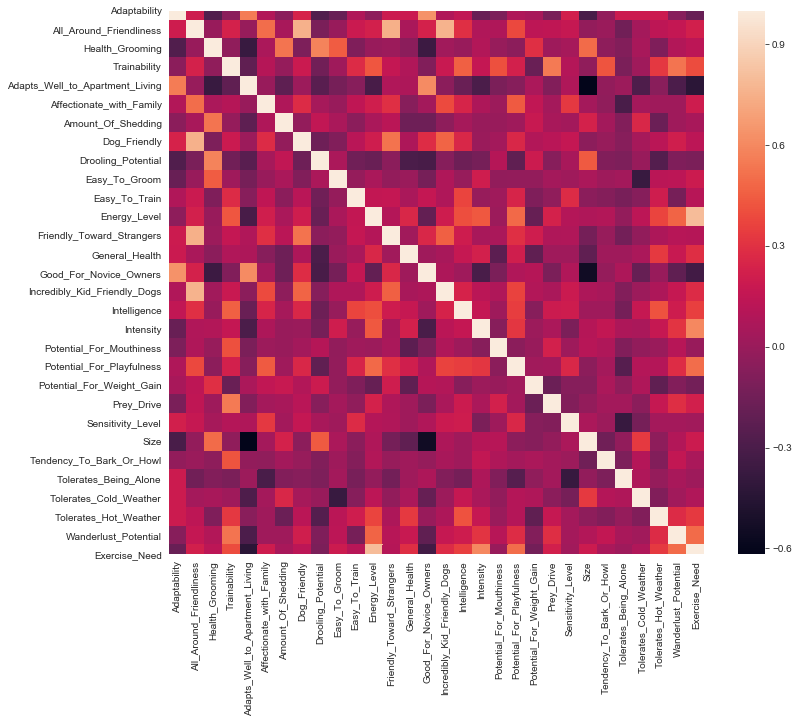

In [97]:
sns.set_style('darkgrid')
plt.figure(figsize=(12,10))
sns.heatmap(dog_desc_corr_df);

In [98]:
#id and remove highly correlated traits to avoid multicolinearity issues in linear reg. models
dog_high_corr = dog_desc_corr_df[(dog_desc_corr_df.abs() > .65) & ~(dog_desc_corr_df == 1)]
for i, row in dog_high_corr.iterrows():
    if row.sum() > 0: 
        print("{} is correlated with: ".format(i), end = '') 
        for ind, col in row.iteritems():
            if ~np.isnan(col):
                print("{} at {}".format(ind, col))
        print("\n")


All_Around_Friendliness is correlated with: Dog_Friendly at 0.7565146009482395
Friendly_Toward_Strangers at 0.7509267951607245
Incredibly_Kid_Friendly_Dogs at 0.7605389789255196


Dog_Friendly is correlated with: All_Around_Friendliness at 0.7565146009482395


Energy_Level is correlated with: Exercise_Need at 0.8029938934844397


Friendly_Toward_Strangers is correlated with: All_Around_Friendliness at 0.7509267951607245


Incredibly_Kid_Friendly_Dogs is correlated with: All_Around_Friendliness at 0.7605389789255196


Exercise_Need is correlated with: Energy_Level at 0.8029938934844397




In [99]:
dog_descr_df = dog_descr_df.drop(columns=["Friendly_Toward_Strangers", "Incredibly_Kid_Friendly_Dogs", "Dog_Friendly", "Intensity",
                                         "Exercise_Need"])

## Feature Augmentation - Combining datasets

I will use the numerical features describing breeds to replace an important but difficult to use feature on the main dataset (dog breed) with a set of ordered numerical features. 


In [100]:
pd.set_option('display.max_columns', 500)
pd.set_option('max_rows', 100)

In [101]:
shelter_inout_df[["breed"]].isna().sum()

breed    0
dtype: int64

In [102]:
shelter_inout_df.shape

(45366, 46)

In [103]:
#for bree in shelter_inout_df.breed.unique():
#    print("\'{}\'".format(bree))
shelter_inout_df.breed.value_counts().sort_values(ascending=False).head()

Pit Bull Mix                 6256
Chihuahua Shorthair Mix      4831
Labrador Retriever Mix       4789
German Shepherd Mix          1950
Australian Cattle Dog Mix    1099
Name: breed, dtype: int64

In [104]:
#the breed field from the shelter db has a lot of mixes and multiple breeds listed. Lets clean that.
shelter_inout_df.breed = shelter_inout_df.breed.str.strip()
#Breed name shouldn't be split
shelter_inout_df.breed = shelter_inout_df.breed.str.replace(r'Black/Tan', 'Black and Tan', regex=False)

shelter_inout_df.breed = shelter_inout_df.breed.str.replace(r'(Miniature |Toy |Standard )?Poodle(?=(?:$)|[$\n \/])', 'Poodle',
                                                            regex=True)  # Not sure if should add a feature for poodle type

In [105]:
def replace_abbr(col, old, new, avoid):
    search_string = r'{}(?=(?:$)|[\n \/])(?!{})'.format(old, avoid) #match old, then nl space or slash, but not avoid
    new_col = col.str.replace(search_string, new, regex=True)
    return new_col

In [106]:
# define breed name changes
breed_abbr_fixes = [['Terr', 'Terrier', 'ier'],  # trying to avoid null in lookahead
                   ['Eng', 'English', ''],
                   ['Port', 'Portuguese', ''],
                   ['Span', 'Spaniel', ''],
                   ['Pinsch', 'Pinscher', 'er'],  #null in neg lookahead seems to cause problem
                   ['Catahoula', 'Catahoula Leopard Dog', ' Leopard Dog'],
                   ['Rhod', 'Rhodesian', 'Rhod'],
                   ['Pit Bull', 'American Pit Bull Terrier', ' Terrier'],
                   ['Anatol Shepherd', 'Anatolian Shepherd Dog', ' Dog'],
                   ['German Shepherd', 'German Shepherd Dog', ' Dog'],
                   ['Black and Tan Hound', 'Black and Tan Coonhound', 'Coon']]
for i in breed_abbr_fixes:
    uncorrected, corrected, avoid = i
    shelter_inout_df.breed = replace_abbr(shelter_inout_df.breed, uncorrected, corrected, avoid)

In [107]:
#check breeds now in dataset
shelter_inout_df.breed.value_counts().sort_values(ascending=False).head()

American Pit Bull Terrier Mix    6425
Chihuahua Shorthair Mix          4831
Labrador Retriever Mix           4789
German Shepherd Dog Mix          1950
Australian Cattle Dog Mix        1099
Name: breed, dtype: int64

In [108]:
def pull_cat_out(df, colname, category):
    df[category] = df[colname].str.contains(r'{}'.format(category), regex=True).astype(int)      
    df[colname] = df[colname].str.replace(r'{}'.format(category), '', regex=True)
    return df

In [109]:
shelter_inout_df[shelter_inout_df.isna().any(1)]

,outcome_type,breed,intake_condition,intake_type,sex_upon_intake,count,age_upon_intake_(days),intake_datetime,intake_weekday,time_in_shelter_days,spring,summer,winter,neutered,male,neutered_in_shelter,color_type,color_type2,Apricot,Black,Blue,Brown,Buff,Chocolate,Cream,Fawn,Gold,Gray,Liver,Orange,Red,Ruddy,Sable,Silver,Tan,Tricolor,White,Yellow,Pink,Tortie,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,Return to Owner,Spinone Italiano Mix,Normal,Stray,Neutered Male,1,3650,2017-12-07 00:00:00,Thursday,0.588194,0,0,0,1,1,0,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0
1,Return to Owner,Spinone Italiano Mix,Normal,Public Assist,Neutered Male,1,2555,2014-12-19 10:21:00,Friday,1.259722,0,0,1,1,1,0,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0
2,Return to Owner,Spinone Italiano Mix,Normal,Public Assist,Neutered Male,1,2190,2014-03-07 14:26:00,Friday,1.113889,0,0,1,1,1,0,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0
3,Transfer,Dachshund,Normal,Owner Surrender,Neutered Male,1,3650,2014-04-02 15:55:00,Wednesday,4.970139,0,0,1,1,1,0,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
4,Return to Owner,Shetland Sheepdog,Injured,Public Assist,Neutered Male,1,5840,2013-11-16 09:02:00,Saturday,0.119444,0,0,1,1,1,0,None,None,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
5,Return to Owner,Labrador Retriever/American Pit Bull Terrier,Aged,Stray,Spayed Female,1,5475,2013-11-16 14:46:00,Saturday,0.870833,0,0,1,1,0,0,None,None,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
6,Return to Owner,Miniature Schnauzer Mix,Normal,Stray,Intact Female,1,5475,2014-11-14 15:11:00,Friday,0.178472,0,0,1,0,0,0,None,None,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,Return to Owner,Lhasa Apso Mix,Normal,Stray,Neutered Male,1,5475,2014-09-15 11:28:00,Monday,0.213194,0,0,1,1,1,0,None,None,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
8,Return to Owner,Shetland Sheepdog Mix,Normal,Public Assist,Neutered Male,1,5475,2014-03-17 09:45:00,Monday,6.258333,0,0,1,1,1,0,None,None,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
9,Return to Owner,Shetland Sheepdog Mix,Normal,Stray,Spayed Female,1,6570,2015-09-18 17:46:00,Friday,0.054167,0,0,1,1,0,0,None,None,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [110]:
breed_cats = ['Shorthair', 'Longhair', 'Wirehair', 'Rough Coat', 'Mix']
for cat_i in breed_cats:
    shelter_inout_df = pull_cat_out(shelter_inout_df, "breed", cat_i)

In [111]:
#reorder columns so i can see column i am using a lot
shelter_inout_df = shelter_inout_df.reindex(columns=(['breed'] + list([a for a in shelter_inout_df.columns if a != 'breed']) ))

In [112]:
shelter_inout_df.breed = shelter_inout_df.breed.str.strip()

In [113]:
# get breed names x & y for x y mix
shelter_inout_df[["breed", "breed2"]] = shelter_inout_df.breed.str.split(pat="/", expand=True, n=1)

In [114]:
shelter_inout_df.breed.value_counts().sort_values(ascending=False).head()

American Pit Bull Terrier    7055
Labrador Retriever           6260
Chihuahua                    5422
German Shepherd Dog          2612
Dachshund                    1442
Name: breed, dtype: int64

In [115]:
# run again after replacing names
shelter_inout_df.breed = shelter_inout_df.breed.str.strip()
shelter_inout_df.breed2 = shelter_inout_df.breed2.str.strip()

In [116]:
#Breed names with multiple matches - just the Black/Tan. fixed in cell above now.
#NotNeeded shelter_inout_df[shelter_inout_df.breed.str.contains("/[\w\s]+/", regex=True)]["breed"]

In [117]:
#lets find which breed names exist in shelter info but not breed info df, and add add fixes to the feature above
dog_descr_df.index.names = ['breed']  
shelter_dog_list_df = pd.DataFrame(pd.concat([shelter_inout_df.breed, shelter_inout_df.breed2], axis=0) \
                                   ).rename(columns={0:"breed"})
shelter_breed_list_df = pd.merge(left=shelter_dog_list_df, right=dog_descr_df, left_on='breed', right_on="breed", indicator=True,
                                  how='outer')
shelter_only_breeds_df = shelter_breed_list_df[shelter_breed_list_df._merge == 'left_only']
shelter_only_breeds_df["breed"].value_counts().sort_values(ascending=False).head()

Staffordshire        453
Plott Hound          388
Chinese Sharpei      236
Queensland Heeler    210
English Bulldog      131
Name: breed, dtype: int64

In [118]:
#merge dataframes on cleaned breed columns
shelter_inout_wbreeds_df = pd.merge(left=shelter_inout_df, right=dog_descr_df, left_on="breed", right_index=True, how='left')


In [119]:
shelter_inout_wbreeds_df.describe()

,count,age_upon_intake_(days),time_in_shelter_days,spring,summer,winter,neutered,male,neutered_in_shelter,Apricot,Black,Blue,Brown,Buff,Chocolate,Cream,Fawn,Gold,Gray,Liver,Orange,Red,Ruddy,Sable,Silver,Tan,Tricolor,White,Yellow,Pink,Tortie,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Shorthair,Longhair,Wirehair,Rough Coat,Mix,Adaptability,All_Around_Friendliness,Health_Grooming,Trainability,Adapts_Well_to_Apartment_Living,Affectionate_with_Family,Amount_Of_Shedding,Drooling_Potential,Easy_To_Groom,Easy_To_Train,Energy_Level,General_Health,Good_For_Novice_Owners,Intelligence,Potential_For_Mouthiness,Potential_For_Playfulness,Potential_For_Weight_Gain,Prey_Drive,Sensitivity_Level,Size,Tendency_To_Bark_Or_Howl,Tolerates_Being_Alone,Tolerates_Cold_Weather,Tolerates_Hot_Weather,Wanderlust_Potential
count,45366.0,45366.000000,45366.000000,45366.000000,45366.000000,45366.000000,45366.000000,45366.000000,45366.000000,45366.000000,45366.000000,45366.000000,45366.000000,45366.000000,45366.000000,45366.000000,45366.000000,45366.000000,45366.000000,45366.000000,45366.000000,45366.000000,45366.000000,45366.000000,45366.000000,45366.000000,45366.000000,45366.000000,45366.000000,45366.000000,45366.000000,45366.000000,45366.000000,45366.000000,45366.000000,45366.000000,45366.000000,45366.000000,45366.000000,45366.000000,45366.000000,45366.000000,42815.000000,42815.000000,42815.000000,42815.000000,42815.000000,42815.000000,42815.000000,42815.000000,42815.000000,42815.000000,42815.000000,42815.000000,42815.000000,42815.000000,42815.000000,42815.000000,42815.000000,42815.000000,42815.000000,42815.000000,42815.000000,42815.000000,42815.000000,42815.000000,42815.000000
mean,1.0,978.326456,15.897242,0.001168,0.000573,0.997774,0.801768,0.535291,0.410748,0.001675,0.344752,0.056276,0.258960,0.014681,0.028832,0.018714,0.013005,0.004365,0.018781,0.001587,0.000882,0.057532,0.000022,0.016422,0.003835,0.203170,0.054071,0.531984,0.016378,0.000088,0.000022,0.147930,0.148305,0.131023,0.138430,0.143213,0.151325,0.140171,0.013975,0.004056,0.000794,0.770908,3.014504,4.145019,3.029966,3.705384,3.091276,4.864113,3.429499,1.587761,4.205092,4.025599,4.171809,3.077052,2.788766,4.287866,3.887913,4.590681,3.531192,3.233259,4.321009,2.732243,3.268364,1.733388,2.580591,2.925844,3.264884
std,0.0,1107.420744,44.430504,0.034160,0.023933,0.047132,0.398672,0.498759,0.491975,0.040896,0.475292,0.230456,0.438069,0.120272,0.167336,0.135516,0.113298,0.065921,0.135751,0.039807,0.029681,0.232859,0.004695,0.127093,0.061813,0.402362,0.226161,0.498981,0.126925,0.009390,0.004695,0.355035,0.355406,0.337429,0.345354,0.350294,0.358369,0.347168,0.117389,0.063557,0.028159,0.420253,0.375538,0.687946,0.717494,0.558940,1.556531,0.405888,1.202147,1.000467,1.312164,1.062906,0.871479,0.985374,1.110405,0.683013,1.144478,0.687184,1.020806,1.006814,0.731414,1.209232,0.965666,0.894145,1.183572,0.792617,1.047801
min,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,2.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.0,270.000000,2.093229,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,4.000000,3.000000,3.000000,2.000000,5.000000,2.000000,1.000000,4.000000,4.000000,3.000000,2.000000,2.000000,4.00000

In [120]:
#check for nulls on merged fields
shelter_inout_wbreeds_df[shelter_inout_wbreeds_df.Adaptability.notna()].shape

(42815, 77)

In [121]:
shelter_inout_wbreeds_df[shelter_inout_wbreeds_df.Adaptability.isna()].shape

(2551, 77)

In [122]:
shelter_inout_wbreeds_df[shelter_inout_wbreeds_df["Affectionate_with_Family"].isna()].head()

,breed,outcome_type,intake_condition,intake_type,sex_upon_intake,count,age_upon_intake_(days),intake_datetime,intake_weekday,time_in_shelter_days,spring,summer,winter,neutered,male,neutered_in_shelter,color_type,color_type2,Apricot,Black,Blue,Brown,Buff,Chocolate,Cream,Fawn,Gold,Gray,Liver,Orange,Red,Ruddy,Sable,Silver,Tan,Tricolor,White,Yellow,Pink,Tortie,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Shorthair,Longhair,Wirehair,Rough Coat,Mix,breed2,Adaptability,All_Around_Friendliness,Health_Grooming,Trainability,Adapts_Well_to_Apartment_Living,Affectionate_with_Family,Amount_Of_Shedding,Drooling_Potential,Easy_To_Groom,Easy_To_Train,Energy_Level,General_Health,Good_For_Novice_Owners,Intelligence,Potential_For_Mouthiness,Potential_For_Playfulness,Potential_For_Weight_Gain,Prey_Drive,Sensitivity_Level,Size,Tendency_To_Bark_Or_Howl,Tolerates_Being_Alone,Tolerates_Cold_Weather,Tolerates_Hot_Weather,Wanderlust_Potential
0,Spinone Italiano,Return to Owner,Normal,Stray,Neutered Male,1,3650,2017-12-07 00:00:00,Thursday,0.588194,0,0,0,1,1,0,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Spinone Italiano,Return to Owner,Normal,Public Assist,Neutered Male,1,2555,2014-12-19 10:21:00,Friday,1.259722,0,0,1,1,1,0,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Spinone Italiano,Return to Owner,Normal,Public Assist,Neutered Male,1,2190,2014-03-07 14:26:00,Friday,1.113889,0,0,1,1,1,0,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,Staffordshire,Euthanasia,Injured,Stray,Spayed Female,1,5840,2015-04-28 15:08:00,Tuesday,0.940278,0,0,1,1,0,0,None,None,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,Queensland Heeler,Euthanasia,Aged,Euthanasia Request,Intact Male,1,4745,2015-03-13 15:20:00,Friday,0.070139,0,0,1,0,1,0,Merle,None,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [123]:
print(shelter_inout_wbreeds_df.isna().sum().to_string())

breed                                  0
outcome_type                           2
intake_condition                       0
intake_type                            0
sex_upon_intake                        0
count                                  0
age_upon_intake_(days)                 0
intake_datetime                        0
intake_weekday                         0
time_in_shelter_days                   0
spring                                 0
summer                                 0
winter                                 0
neutered                               0
male                                   0
neutered_in_shelter                    0
color_type                         41857
color_type2                        44675
Apricot                                0
Black                                  0
Blue                                   0
Brown                                  0
Buff                                   0
Chocolate                              0
Cream           

we have most of the records identified to dog breeds that are in the dog breed description dataset. Most of the remaining most common dog breeds are not in the set or are ambiguous (eg there are two breeds know as 'Staffordshire'. )

In [124]:
shelter_inout_wbreeds_df = shelter_inout_wbreeds_df.dropna(subset=['breed'])

In [125]:
# Average breed data for animals with two breeds listed
field_list = dog_descr_df.columns.to_list()
shelter_inout_wbreeds_df = pd.merge(left=shelter_inout_wbreeds_df, right=dog_descr_df, left_on="breed2", right_index=True, 
                                    how='left', suffixes=('','_b2'))

In [126]:
field_list_b2 = []
for field in field_list:
    shelter_inout_wbreeds_df.loc[shelter_inout_wbreeds_df["breed2"].notna(), field] = \
    (shelter_inout_wbreeds_df[shelter_inout_wbreeds_df["breed2"].notna()][field] +
    shelter_inout_wbreeds_df[shelter_inout_wbreeds_df["breed2"].notna()][field + "_b2"] )/2
    field_list_b2.append(field + "_b2")
shelter_inout_wbreeds_df = shelter_inout_wbreeds_df.drop(columns=field_list_b2)

In [127]:
#fill nulls create because breed was not found in breed desc, with column mean
for colname, col in dog_descr_df.iteritems():
    shelter_inout_wbreeds_df.loc[:,colname] = shelter_inout_wbreeds_df[[colname]].fillna(shelter_inout_wbreeds_df[colname].mean(), 
                                                                                         axis=1)


In [128]:
shelter_inout_wbreeds_df.pivot_table(values='breed', columns="intake_condition", index='intake_type', aggfunc=len)

intake_condition,Aged,Feral,Injured,Normal,Nursing,Other,Pregnant,Sick
intake_type,,,,,,,,
Euthanasia Request,34.0,NaN,10.0,74.0,NaN,1.0,NaN,63.0
Owner Surrender,56.0,NaN,189.0,8267.0,90.0,9.0,4.0,309.0
Public Assist,18.0,NaN,91.0,3891.0,24.0,26.0,1.0,52.0
Stray,169.0,8.0,1503.0,29328.0,471.0,59.0,27.0,592.0


In [129]:
#Both condition and type seem relevant and can't be eliminated
shelter_inout_wbreeds_df = pd.concat([shelter_inout_wbreeds_df, 
           pd.get_dummies(shelter_inout_wbreeds_df.intake_condition, drop_first=True, prefix="in_cond")], axis=1)


In [130]:
shelter_inout_wbreeds_df = pd.concat([shelter_inout_wbreeds_df, 
           pd.get_dummies(shelter_inout_wbreeds_df.intake_type, drop_first=True, prefix="in_type")], axis=1)
shelter_inout_wbreeds_df = shelter_inout_wbreeds_df.drop(columns = ['breed', 'breed2'])

### Feature Engineering


## Feature Selection

In [131]:
X = shelter_inout_wbreeds_df.loc[:, (shelter_inout_wbreeds_df.columns[shelter_inout_wbreeds_df.dtypes != 'object'].values)]\
    .drop(columns='time_in_shelter_days')
y = shelter_inout_wbreeds_df['time_in_shelter_days']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

In [133]:
X_corr_ = X.corr().abs()
X_corr_filt = X_corr_[(X_corr_ > .8) & ~(X_corr_ == 1)]
for i, row in X_corr_filt.iterrows():
    if row.sum() > 0: 
        print("{} is correlated with: ".format(i), end = '') 
        for ind, col in row.iteritems():
            if ~np.isnan(col):
                print("{} at {}".format(ind, col))
        print("\n")


Health_Grooming is correlated with: Amount_Of_Shedding at 0.8342561284777321


Adapts_Well_to_Apartment_Living is correlated with: Size at 0.8216204546413958


Amount_Of_Shedding is correlated with: Health_Grooming at 0.8342561284777321


Size is correlated with: Adapts_Well_to_Apartment_Living at 0.8216204546413958




In [134]:
X = X.drop(columns=['Health_Grooming', 'Adapts_Well_to_Apartment_Living'])

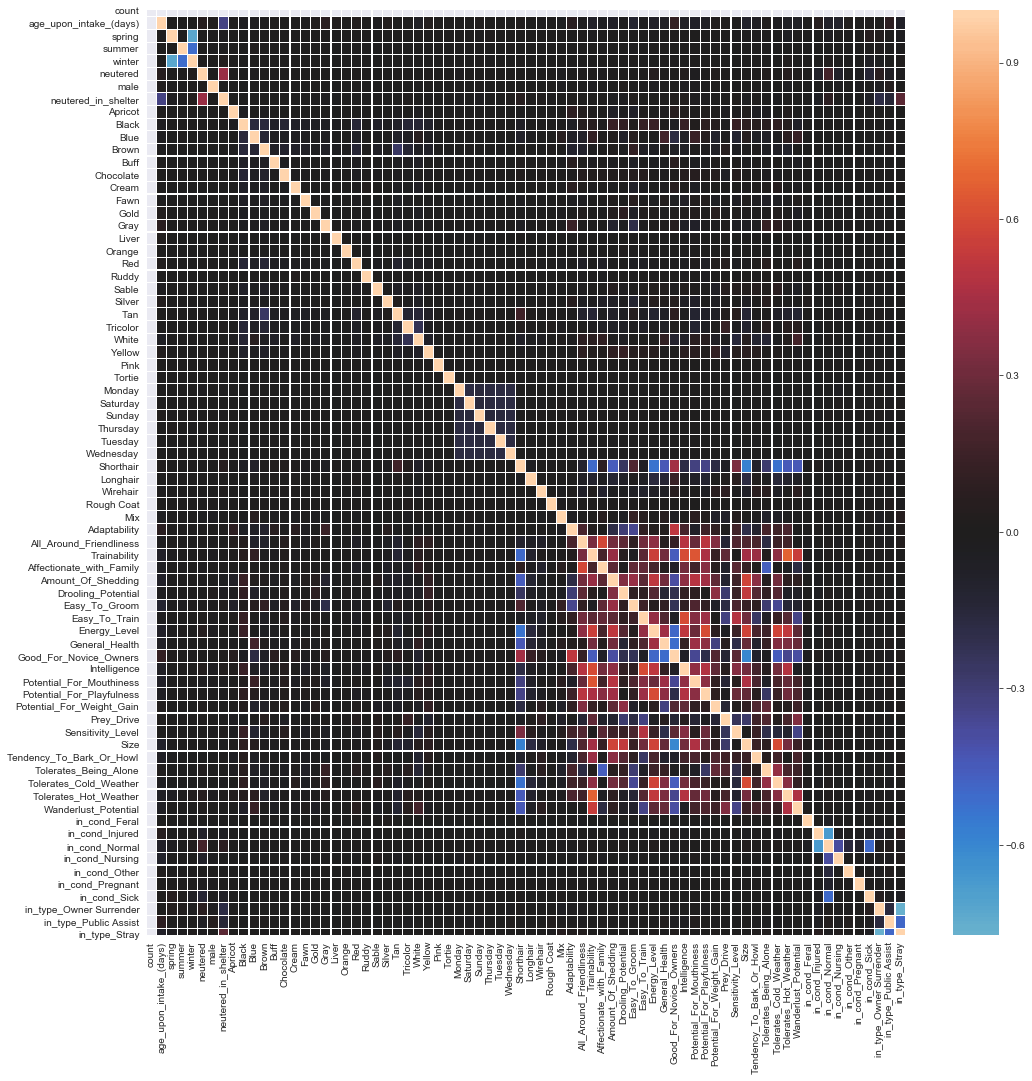

In [135]:
#look features with high correlations to multiple features
sns.set_style('darkgrid')
fig = plt.figure(figsize=(17,17))
ax = sns.heatmap(X.corr(), center=0, linewidths=.1)

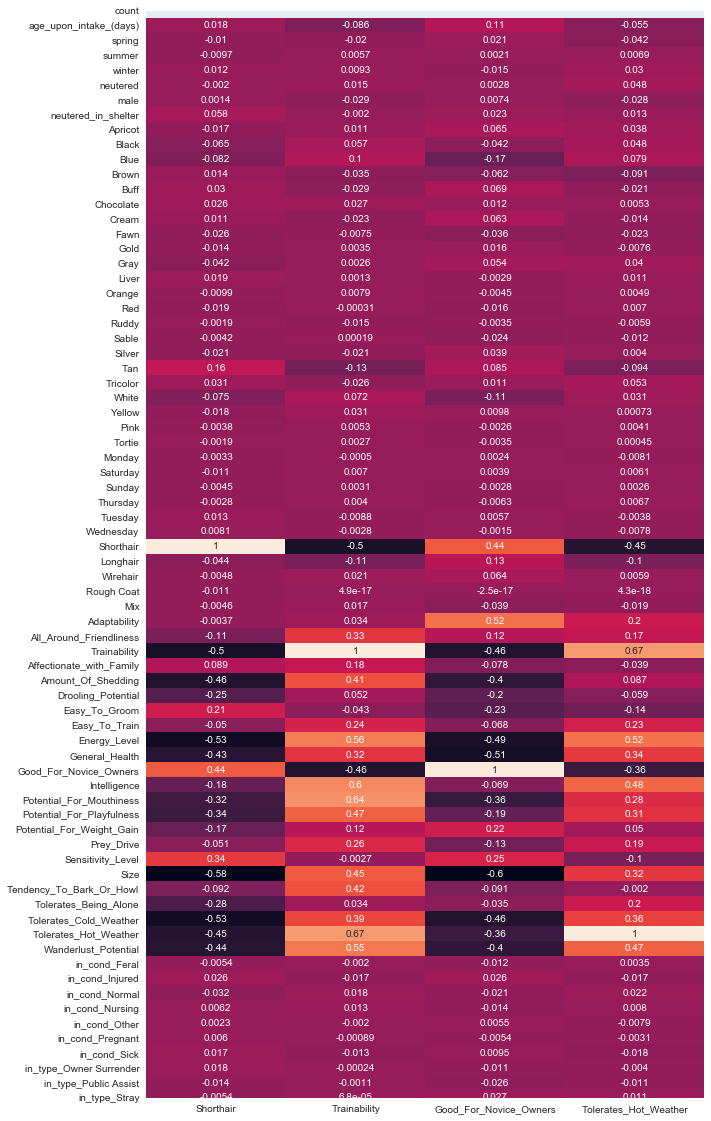

In [136]:
plt.figure(figsize=(10,20))
sns.heatmap(annot=True, cbar=False,  data=X.corr().loc[:, X.corr().index.isin(['Shorthair', 'Trainability', 'Good_For_Novice_Owners', 'in_type_Owner_Surrender', 
                                 'Tolerates_Hot_Weather']) ]);


In [137]:
X = X.drop(columns=['Shorthair'])

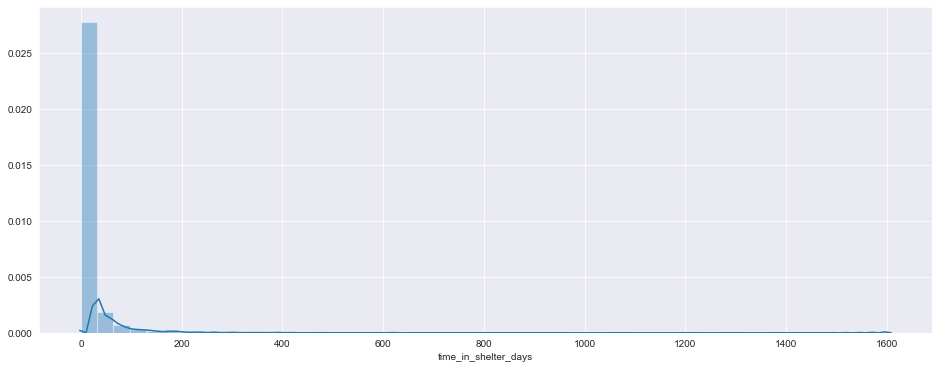

In [138]:
plt.figure(figsize=(16, 6))
sns.distplot(y_train);

In [139]:
# %load ../thinkful_notes/utility/numerical.py
#!/usr/bin/env python

# In[1]:
def winsorize(data=[], lower=5, upper=95):
    '''Winsorizes an array. Defaults are at 5 (%) and 95 (%). 
    '''
    pcts = np.percentile(data, q=[lower, upper])
    w_ized = []
    for i in data:
        if i<pcts[0]:
            w_ized.append(pcts[0])
        elif i>pcts[1]:
            w_ized.append(pcts[1])
        else: 
            w_ized.append(i)
    return w_ized

In [140]:
#need to figure out why this is a tuple
#y_train = y_train[0]

In [141]:
#There are some extreme outliers and a significant right skew. First winsorize extreme outliers
y_train = winsorize(data=y_train, lower=0, upper=99)
y_test = winsorize(data=y_test, lower=0, upper=99)  #keep data consistant

My guess is that the distribution should be a exponential? distribution; outcomes could happen each day. 

In [142]:
#Apply square root transform
y_train = pd.Series(y_train) + .01 # put in series so can add to each element
y_test = pd.Series(y_test) + .01
y_train = boxcox(y_train)[0]  
y_test = boxcox(y_test)[0] 

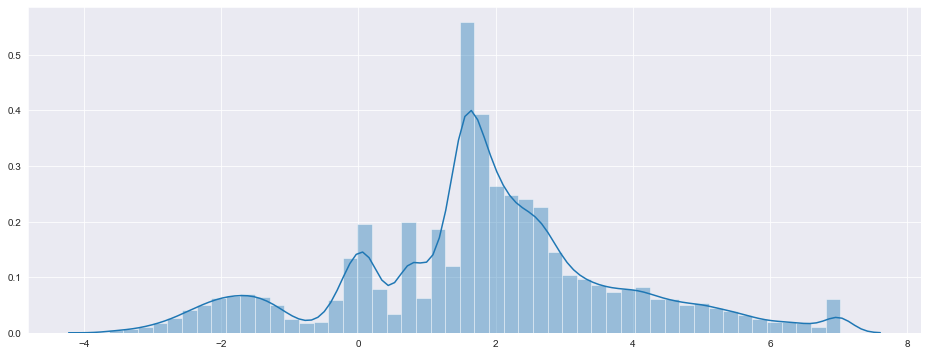

In [143]:
plt.figure(figsize=(16, 6))
sns.distplot(y_train);

This is not a normal distribution but much improved.

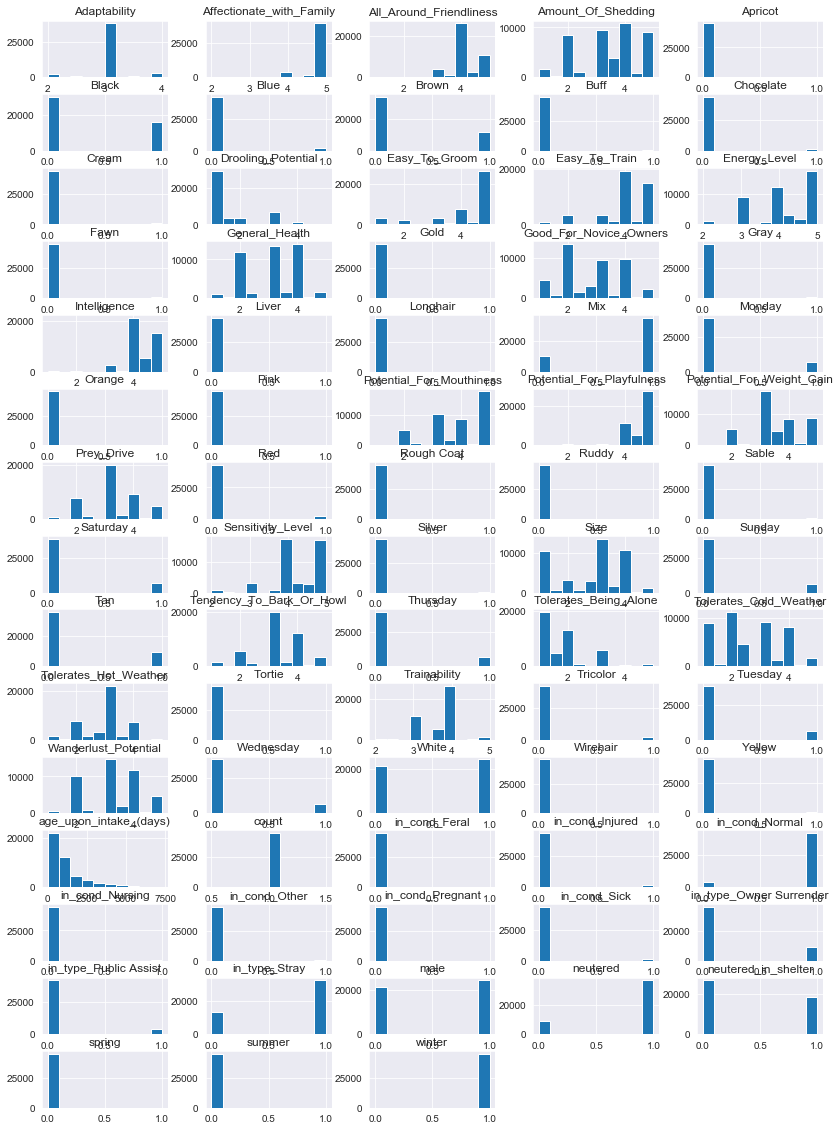

In [144]:
X.hist(layout=(-1,5), figsize=(14,20));    

## Modeling

In [145]:
params = {'alpha': stats.uniform(.0001, 100),
         'l1_ratio': stats.uniform(.1, .9)}
enet = ElasticNet()
enet_rsearch = RandomizedSearchCV(estimator=enet, param_distributions=params, n_iter=12, cv=5)
enet_rsearch.fit(X_train, y_train)
enet_rsearch.cv_results_

{'mean_fit_time': array([0.08377576, 0.07240319, 0.07799025, 0.09325137, 0.07100935,
        0.07380252, 0.06901531, 0.08018422, 0.0686151 , 0.06442752,
        0.05964093, 0.05750265]),
 'std_fit_time': array([0.01090701, 0.00818621, 0.00768643, 0.02379236, 0.01187401,
        0.00427796, 0.00569088, 0.00495251, 0.00865843, 0.00629514,
        0.00247578, 0.0009904 ]),
 'mean_score_time': array([0.008179  , 0.00578599, 0.00745974, 0.00698051, 0.00538702,
        0.0069828 , 0.0057857 , 0.00658603, 0.00618324, 0.00558667,
        0.00558558, 0.00518675]),
 'std_score_time': array([0.00247529, 0.00074713, 0.00210199, 0.00178355, 0.00101742,
        0.00089095, 0.00074623, 0.00079626, 0.00146493, 0.00135259,
        0.00048611, 0.0007465 ]),
 'param_alpha': masked_array(data=[34.281586658805395, 83.6320299764483,
                    31.290081349025343, 55.52331910078484,
                    68.63431174178163, 28.32125582979724,
                    44.01492587413687, 28.795685074076857,
 

In [146]:
print("best r^2 is: {}".format(enet_rsearch.best_score_))

best r^2 is: 0.009956525033406256


In [147]:
rforest_params = {'bootstrap': (True, False),
                 'criterion': ('mse', 'mae'),
                 'max_features': ('auto', 'sqrt'),  
                 #'max_depth': stats.randint(2,120), #TypeError: object of type 'int' has no len()
                 'max_depth': (5, 15, 30, 50, 70),
                 'min_samples_split': (2, 10, 20, 30)}  #stats.randint(1,30)}

rforest = RandomForestRegressor(n_estimators=50, verbose=2, n_jobs=-1)
rforest_rsearch = RandomizedSearchCV(estimator=rforest, param_distributions=rforest_params, n_iter=30, cv=3)
rforest_rsearch.fit(X_train, y_train)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


KeyboardInterrupt: 

In [ ]:
rforest_rsearch.best_estimator_

In [ ]:
rforest_rsearch.best_score_

In [ ]:
rforest_rsearch.best_params_

In [ ]:
rforest_best = RandomForestRegressor(**rforest_rsearch.best_params_, n_estimators=60, n_jobs=-1)

In [ ]:
rforest_best.fit(X_train, y_train)

In [ ]:
rforest_best.feature_importances_

In [ ]:
rforest_best.feature_importances_.shape

In [149]:
#use best hypers from search
random_forest_best = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=20,
                      min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)
randforest_rfe = RFE(random_forest_best, n_features_to_select=40, step=1, verbose=True)
randforest_rfe.fit(X_train, y_train)

Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.
Fitting estimator with 72 features.
Fitting estimator with 71 features.
Fitting estimator with 70 features.
Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 fe

RFE(estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                    max_depth=15, max_features='auto',
                                    max_leaf_nodes=None,
                                    min_impurity_decrease=0.0,
                                    min_impurity_split=None, min_samples_leaf=1,
                                    min_samples_split=20,
                                    min_weight_fraction_leaf=0.0,
                                    n_estimators=60, n_jobs=-1, oob_score=False,
                                    random_state=None, verbose=0,
                                    warm_start=False),
    n_features_to_select=40, step=1, verbose=True)

In [178]:
#see which features were selected
reduced_features = pd.DataFrame(X_train.columns.to_list())[randforest_rfe.support_]
reduced_features

,0
1,age_upon_intake_(days)
5,neutered
6,male
7,neutered_in_shelter
9,Black
11,Brown
24,Tan
26,White
30,Monday
31,Saturday


In [154]:
#see unselected features
original_columns = pd.DataFrame(X_train.columns)
pd.merge(left=pd.DataFrame(X_train.columns), right=reduced_features, left_on=0, right_on=0, how='left', indicator=True).\
query('_merge == "left_only"')

,0,_merge
0,count,left_only
2,spring,left_only
3,summer,left_only
4,winter,left_only
8,Apricot,left_only
10,Blue,left_only
12,Buff,left_only
13,Chocolate,left_only
14,Cream,left_only
15,Fawn,left_only


In [158]:
rf_cv_scores = cross_validate(estimator=randforest_rfe, X=X_train, y=y_train, n_jobs=-1, return_estimator=True, cv=4)
rf_cv_scores['test_score']

array([0.31763026, 0.28967538, 0.29057609, 0.30190862])

In [235]:
#review important features
X_train_reduced = X_train.loc[:,X_train.columns.isin(reduced_features.values.flatten())]
rfit = randforest_rfe.estimator_.fit(X_train_reduced, y_train)

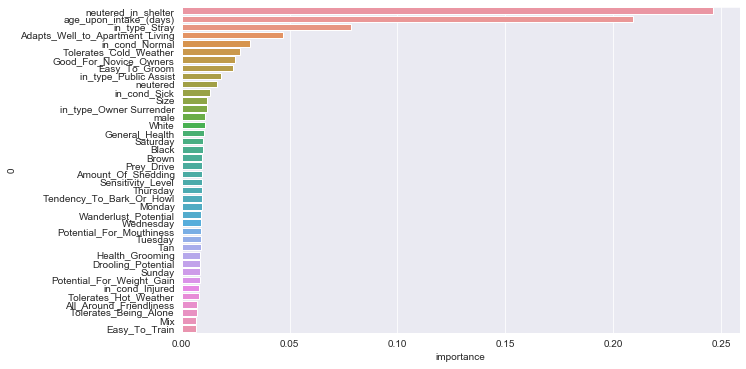

In [230]:
important_features = pd.DataFrame(data=rfit.feature_importances_, index=reduced_features[0])
important_features.columns = ['importance']
important_features.sort_values(by='importance', ascending=False,inplace=True)
figimp = plt.figure(figsize=(10,6))
aximp = sns.barplot(y=important_features.index, x=important_features['importance'], orient='h');

In [236]:
params = {'alpha': stats.uniform(.0001, 100),
         'l1_ratio': stats.uniform(.1, .9)}
enet_red = ElasticNet()
enet_red_rsearch = RandomizedSearchCV(estimator=enet, param_distributions=params, n_iter=12, cv=5)
enet_red_rsearch.fit(X_train_reduced, y_train)
enet_red_rsearch.cv_results_

{'mean_fit_time': array([0.03450723, 0.03271217, 0.03191414, 0.03251271, 0.03111725,
        0.0321135 , 0.03570447, 0.03211427, 0.03211422, 0.03191619,
        0.03231168, 0.02952085]),
 'std_fit_time': array([0.00312741, 0.00369929, 0.00126135, 0.00101822, 0.00116351,
        0.00074681, 0.00353529, 0.00116315, 0.00146605, 0.00109128,
        0.00101778, 0.00119598]),
 'mean_score_time': array([0.00319166, 0.00319304, 0.00359273, 0.00379047, 0.00398965,
        0.00319171, 0.00339117, 0.00339108, 0.00319185, 0.00338993,
        0.00319195, 0.00259333]),
 'std_score_time': array([3.99375456e-04, 1.16423612e-03, 4.90372272e-04, 7.47082380e-04,
        6.46813391e-07, 3.98756025e-04, 4.88792130e-04, 4.88480475e-04,
        7.46378729e-04, 4.87275261e-04, 3.99351504e-04, 4.89142416e-04]),
 'param_alpha': masked_array(data=[58.944248927550504, 22.093987297986526,
                    53.39639846945266, 31.972312195575544,
                    86.77136312155439, 6.75900094578847, 4.224341516

In [238]:
from sklearn.neighbors import KNeighborsRegressor
kn_params = {'n_neighbors': (3, 4, 6, 8),
          'weights': ('uniform', 'distance'),
          'algorithm': ('auto', 'ball_tree', 'kd_tree', 'brute')}
knr = KNeighborsRegressor()
knrrsear = RandomizedSearchCV(estimator=knr, param_distributions=kn_params, n_jobs=-1, n_iter=12, cv=3)


In [239]:
knrrsear.fit(X_train_reduced, y_train)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                                 metric='minkowski',
                                                 metric_params=None,
                                                 n_jobs=None, n_neighbors=5,
                                                 p=2, weights='uniform'),
                   iid='warn', n_iter=12, n_jobs=-1,
                   param_distributions={'algorithm': ('auto', 'ball_tree',
                                                      'kd_tree', 'brute'),
                                        'n_neighbors': (3, 4, 6, 8),
                                        'weights': ('uniform', 'distance')},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=0)

In [241]:
knrrsear.best_estimator_

KNeighborsRegressor(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=8, p=2,
                    weights='uniform')

In [242]:
knrrsear.best_score_

0.12477598440379324

In [ ]:
from sklearn.svm import SVR
svr_params = {'C': (.4, .7, 1, 1.3, 2, 10),
              'epsilon': (.001, .01, .1), 
              'kernel': ('linear', 'poly', 'rbf')}
svr = SVR()
svr_search = RandomizedSearchCV(estimator=svr, param_distributions=svr_params, n_jobs=-1, n_iter=12, cv=3)
svr_search.fit(X_train_reduced, y_train)

In [ ]:
svr_search.best_score_